# 1회차


# Data

고객이 대출금을 상환할 것인지, 아니면 상환이 어려운지를 예측하는 것은 매우 중요합니다. 

데이터 소스는 7가지 입니다.
- __application_train/test__: Home Credit의 대출 지원자에 대한 정보가 담겨 있습니다. 각 대출마다 하나의 행으로 이루어져 있으며, SK_ID_CURR로 신원이 구분됩니다. training application 데이터에는 target이 포함되어 있습니다. 0: 대출금이 상환됨, 1: 대출금이 상환되지 않음
- __bureau__: 고객이 다른 금융 기관에서의 이전 신용에 관한 데이터입니다. 각 이전 신용에는 하나의 열이 있지만, 하나의 application data의 한 대출에 대해서는 여러 이전 신용이 있을 수 있습니다.
- __bureau_balance__: bureau의 이전 신용의 월별 데이터입니다. 각 행은 이전 크레딧의 한달이며, 각 이전 신용은 신용 기간에 따라 (월별이므로)여러 행을 가질 수 있습니다. 
- __previous_application__: 어플리케이션 데이터에 있는 Home Credit의 고객 중 이전에도 대출을 신청했던 사람들에 대한 데이터입니다. 각 어플리케이션 데이터의 현재 대출은 여러 이전 대출을 가질 수 있습니다. 각 이전 지원은 하나의 행을 가지고 SK_ID_PREV 피처로 식별됩니다.
- __POS_CASH_BALANCE__: 이전 판매 시점 또는 고객이 Home Credit에서 대출을 했던 월별 데이터입니다. 각 행은 이전 판매 시점 또는 현금 대출의 한 달이며, 단일 이전 대출에는 여러 행이 있을 수 있습니다.
- __credit_card_balance__: 고객으 Home Credit에 가지고 있던 이전 신용카드에 대한 월별 데이터입니다. 각 행은 신용카드 잔액의 한달이며, 하나의 신용카드는 여러행을 가질 수 있습니다.
- __installments_payment__: Home Credit의 이전 대출에 대한 결제 내역입니다. 결제 시마다 한 행씩, 결제 누락 시 한 행씩 있습니다.

또한 모든 열의 정의(HomeCredit_columns_description.csv에 제공)와 예상 제출 파일의 예가 제공됩니다.

이 노트북에서는 주요 application training, test 데이터만 계속 사용할 것입니다. 진지하게 경쟁하려면 모든 데이터를 사용해야 하지만, 지금은 좀 더 관리하기 쉬운 파일 하나를 고수할 것입니다.

# Metric: ROC AUC
제출시 점수가 판단되는 지표를 이해할 필요가 있습니다. 이 경우, Receiver Operating Characteristc Area Under the Curve(ROC AUC, AUROC라고도 함)으로 알려진 공통 분류 메트릭입니다.

ROC AUC는 두 가지 개념만 이해할 수 있다면 비교적 간단합니다. ROC 곡선은 false positive 비율에 대한 true positive 비율을 그래프로 나타냅니다.

그래프의 한 선은 단일 모형을 나타내고, 선을 따라 이동하면 양의 인스턴스를 분류하는데 사용되는 임계값이 변경되었음을 나타냅니다. 임계값은 오른쪽 상단의 0에서 시작하여 왼쪽 하단의 1로 이동합니다. 왼쪽과 다른 곡선 위에 있는 곡선은 더 나은 모형을 나타냅니다.

곡선 아래의 영역(AUC)은 ROC 곡선 아래의 영역입니다(곡선의 적분). 랜덤하게 추측하는 모형은 ROC AUC가 0.5입니다.

ROC AUC에 따라 분류기를 측정할 때 0 또는 1개의 예측을 생성하는 것이 아닌 0과 1사이의 확률을 생성합니다. 

이제 데이터 탐색에 대해 알아보겠습니다.

# Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

# Read in Data
첫번째로, 사용가능한 파일을 살펴보겠습니다. 9개의 파일중 1개의 트레이닝/테스팅 파일, 1개의 제출 예 파일, 6개의 대출에 관한 정보를 가지고 있는 파일입니다.

In [9]:
print(os.listdir('./input/'))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [10]:
# Training data
app_train = pd.read_csv('./application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


트레이닝 데이터는 307511의 관측치(대출)과 122개의 피처(타겟 포함)로 이루어졌습니다.

In [11]:
# Testing data features
app_test = pd.read_csv('./input/application_test.csv')
print('Testing data shape:', app_test.shape)
app_test.head()

Testing data shape: (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


타겟 컬럼이 없는 것을 알 수 있습니다.

# Exploratory Data Analysis
EDA는 통계량을 계산하고 수치를 만들어 데이터 내의 추세, 이상 징후, 패턴 또는 관계를 찾는 개방형 프로세스입니다. EDA의 목표는 데이터가 우리에게 무엇을 알려줄 수 있는지 배우는 것입니다. 일반적으로 높은 수준의 오버뷰로 시작한 다음 흥미로운 데이터 영역을 찾을 때 특정 영역으로 좁혀집니다. 연구 결과는 그 자체로 흥미로울 수도 있고, 어떤 기능을 사용할지 결정하는 데 도움을 줌으로써 우리의 모델 선택에 정보를 제공하는 데 사용될 수도 있습니다.

## Examine the Distribution of the Target Column

In [12]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='Frequency'>

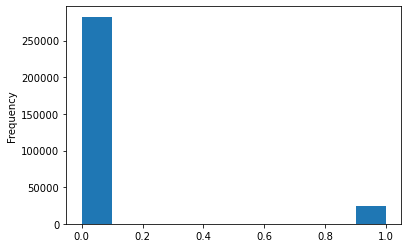

In [13]:
app_train['TARGET'].astype(int).plot.hist()

데이터가 불균형 합니다. 더 많은 사람이 대출을 상환했습니다. 더 나은 머신러닝 모델을 위해서는 가중치를 주어 불균형을 해소해야 합니다.

## Examine Missing Values
각 열의 얼마나 결측치를 가지고 있는지 살펴보겠습니다.

In [20]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: "% of Total Values"})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print('Your selected dataframe has' + str(df.shape[1]) + ' columns.\n' 'There are ' + str(mis_val_table_ren_columns.shape[0]) + ' columns that have missing values.')
    
    # Return the dataframe with missing function
    return mis_val_table_ren_columns
    

In [21]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


머신 러닝 모델을 구축할 때가 되면 이러한 결측값을 채워야 합니다. 이후 작업에서는 imputation 없이 결측값을 처리할 수 있는 XGBoost 등의 모델을 사용할 예정입니다. 결측값 비율이 높은 열을 삭제하는 방법도 있지만, 이러한 열이 모형에 도움이 되는지 여부를 미리 알 수는 없습니다. 따라서 일단은 모든 칼럼을 보관하도록 하겠습니다.

## Column Types
컬럼들의 데이터 타입을 살펴보겠습니다.

In [23]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

이번엔 object 타입의 컬럼을 살펴보겠습니다.

In [25]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

대부분의 범주형 변수들이 상대적으로 작은 고유값들을 가지고 있습니다.

## Encoding Categorical Vars
머신러닝 모델을 범주형 변수를 처리할 수 없습니다. (LightGBM 같은 일부 모델 제외) 따라서 숫자로 인코딩하는 방법을 찾아야 합니다. 이 프로세스를 수행하는 두 가지 주요 방법은 다음과 같습니다.
- Label encoding: 범주형 변수의 각 고유 범주를 정수로 할당합니다. 
- One-hot encoding: 범주형 변수의 각 고유 범주에 대한 새 열을 만듭니다. 각 관측치는 해당 범주에 대한 열의 1과 다른 모든 새 열의 0을 수신합니다.

라벨 인코딩의 문제는 카테고리에 임의 순서를 부여한다는 것입니다. 각 범주에 할당된 값은 랜덤이며 범주의 고유한 측면을 반영하지 않습니다. 따라서 라벨 인코딩을 수행할 때 모델은 피처의 상대적 값을 사용하여 우리가 원치 않는 가중치를 부여할 수 있습니다. 범주형 변수(예: 남/여)에 대해 고유값이 두개만 있으면 라벨 인코딩도 좋지만 두개 이상인 경우에는 원핫인코딩이 안전 합니다.

이러한 접근 방식의 상대적인 장점에 대한 논쟁이 있으며, 일부 모델에서는 라벨 인코딩된 범주형 변수를 문제 없이 처리할 수 있습니다. 클래스가 많은 범주형 변수에 대해서는 임의의 값을 범주에 부과하지 않기 때문에 원핫 인코딩이 가장 안전한 방법입니다. 원핫 인코딩의 유일한 단점은 피처 수가 많은 범주형 데이터에서 피처수가 매우 증가합니다. 이를 해결하기 위해 PCA 또는 기타 차원 축소 방법에 따라 원핫 인코딩을 수행하여 차원 수를 줄일 수 있습니다.

이 노트북에서는 범주가 2개만 있는 범주형 변수에 대해 라벨 인코딩을 사용하고 2개 이상인 변수에 대하 원핫 인코딩을 사용합니다.

### Label Encoding and One-Hot Encoding
라벨 인코딩의 경우 sklearn 을 사용하고 원핫 인코딩의 경우 pandas을 사용합니다.

In [26]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded' % le_count)

3 columns were label encoded


In [32]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


### Aligning Training and Testing Data
트레이닝 데이터와 테스트 데이터 모두에 동일한 피처가 있어야 합니다. 원핫 인코딩은 테스트 데이터에 범주를 표시하지 않는 일부 범주형 변수가 있기 때문에 트레이닝 데이터에 더 많은 열을 생성했습니다. 테스트 데이터에 없는 트레이닝 데이터의 열을 제거하려면 데이터프레임을 정렬해야 합니다. 먼저 트레이닝 데이터에서 타겟 열을 추출합니다. 

In [33]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join='inner', axis=1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape:', app_train.shape)
print('Testing Features shape:', app_test.shape)

Training Features shape: (307511, 240)
Testing Features shape: (48744, 239)


이제 동일한 피처가 되었습니다. 원핫 인코딩으로 인해 피처수가 크게 증가했습니다. 어느 시점에서는 데이터셋 크기를 줄이기 위해 차원 축소(관련되지 않은 피처 제거)를 시도할 수 있습니다.

## Back to EDA

### Anomalies ( 이상 징후 )
EDA를 수행할 때 항상 주의해야 하는 한 가지 문제는 데이터 내의 이상 현상입니다. 이는 잘못 입력한 숫자, 측정 장비의 오류 또는 극단적인 측정이 유효할 때 입니다. 이상 징후를 정량적으로 지원하는 한 가지 방법은 describe 메서드를 사용하여 열의 통계를 보는 것입니다. DAYS_BIRTH 열의 숫자는 현재 대출 신청서에 상대적으로 기록되므로 음수입니다. 연도별 통계를 보려면 -일을 곱하고 일 수로 나누면 됩니다.

In [35]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

나이가 합리적으로 보입니다. 이상치도 관측되지 않습니다. 고용일은 어떨까요?

In [36]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

옳지 않아 보입니다. 최댓값이 1000년을 넘습니다.

Text(0.5, 0, 'Days Employment')

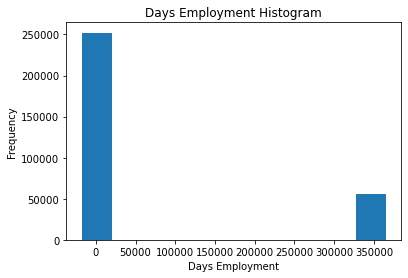

In [37]:
app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

단지 호기심으로, 변칙적인 고객들을 선별해서 다른 고객들보다 채무불이행율이 높은지 알아보겠습니다.

In [38]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


이상 징후는 기본 설정 비율이 더 낮은 것으로 나타났습니다.

이상 징후를 처리하는 것은 규칙이 설정되지 않은 정확한 상황에 따라 달라집니다. 가장 안전한 방법 중 하나는 학습 전에 이상 징후를 결측값으로 설정한 다음 기입하는 것입니다. 이 경우 모든 이상 징후는 동일 값을 가지기 때문에 모든 대출이 공통점을 공유하는 경우에 대비하여 동일 값으로 채우려고 합니다. 변칙적인 값들은 어느정도 중요한 것 같기 때문에, 우리가 실제로 이 값들을 채웠는지 머신러닝 모델을 알려주고 싶습니다. 해결책으로 숫자가 아닌 변칙값(np.nan)을 채운 다음 값이 변칙적이었는지 여부를 나타내는 bool 열을 새로 만들 것입니다.

Text(0.5, 0, 'Days Employment')

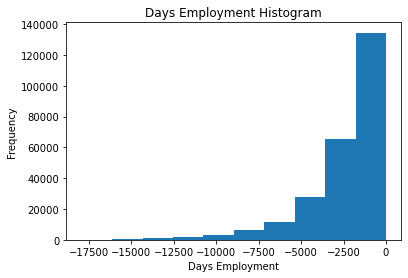

In [39]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

분포가 예상했던 것과 훨씬 더 일치하는 것으로 보이며, 또한 이 값들이 원래 비정상적인 것이라는 것을 모형에 알리기 위해 새로운 열을 만들었습니다.(왜냐하면 우리는 일부 값, 아마도 열의 중위수에 nans을 채워야 합니다) 다른 DAYS 열은 명확한 특이치 없이 예상되는 값으로 보입니다.

매우 중요한 참고 사항으로서, 교육 데이터에 대해 우리가 해야하는 모든 작업은 테스트 데이터에도 적용됩니다. 새 열을 만들고 검정 데이터에서 기존 열을 np.nan으로 채우도록 하겠습니다.

In [40]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test['DAYS_EMPLOYED'] == 365243
app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

print('There ane %d anomalies in the test data out of %d entries' % (app_test['DAYS_EMPLOYED_ANOM'].sum(), len(app_test)))

There ane 9274 anomalies in the test data out of 48744 entries


## Correlations
이제 범주형 변수와 특이치를 다루었으므로 EDA을 계속 살펴보겠습니다. 데이터를 이해하려는 한 가지 방법은 피처와 타겟 간의 상관 관계를 찾는 것입니다. corr()을 사용하여 상관 계수를 계산할 수 있습니다.

상관 계수는 피처의 '관련성'을 나타내는 가장 좋은 방법은 아니지만 데이터 내에서 가능한 관계에 대한 아이디어를 제공합니다. 상관계수의 절대값에 대한 일반적인 해석은 다음과 같습니다.
- .00 - .19 : 매우 약함
- .20 - .39 : 약함
- .40 - .59 : 적절함
- .60 - .79 : 강함
- .80 - 1.0 : 매우 강함

In [41]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

가장 양의 상관관계가 높은 DAYS_BIRTH 피처를 살펴보겠습니다.

문서를 살펴보면 DAYS_BIRTH는 대출 시점의 고객 연령(일)입니다. 상관관계는 양수이지만 이 피처의 값은 실제로 음수이므로, 고객의 나이가 들수록 채무불이행(타겟=0)이 발생할 가능성이 적습니다. 헷갈린다면 피처에 절대값을 취하면 상관관계가 음수가 됩니다.

### Effect of Age on Repayment

In [42]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830984513

고객이 나이가 들수록 타겟과 부정적인 선형관계가 형성되는데, 이는 고객이 나이가 들수록 대출금을 제때 상환하는 경우가 더 많다는 것을 의미합니다.

이제 이 변수를 살펴보겠습니다. 먼저 우리는 나이에 대한 히스토그램을 만들 수 있습니다. 

Text(0, 0.5, 'Count')

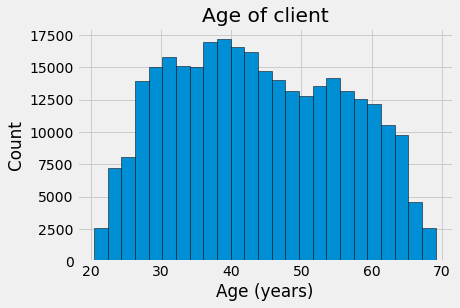

In [43]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor='k', bins = 25)
plt.title('Age of client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

연령의 분포만으로는 이상치가 없다는 것 말고는 별다른게 없습니다. 
나이가 타겟에 미치는 영향을 시각화하기 위해 타겟값으로 색칠된 KDE 그림을 만들 것입니다. kde는 단일 변수의 분포를 나타냅니다. 

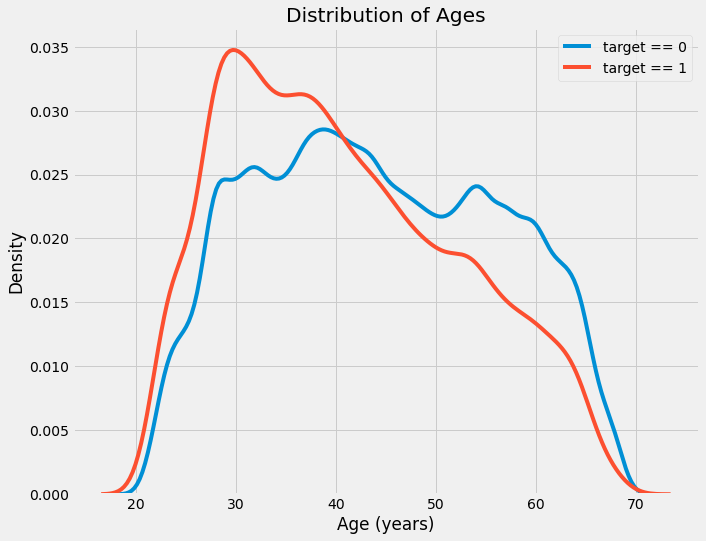

In [46]:
plt.figure(figsize=(10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend()
plt.show()

타겟 == 1 곡선은 젊은 쪽을 향해 기울어져 있습니다. 유의한 상관 계수는 아니지만 이 변수는 타겟에 영향을 미치기 때문에 머신러닝 모델에 유용할 수 있습니다. 다른 방법으로 이 관계를 보자면, 평균 연령대별 대출 상환 실채입니다.

이 그래프를 만들기 위해, 먼저 연령 범주를 각각 5년씩의 구간으로 잘라냅니다. 그런 다음 각 구간에 대해 목표값의 평균값을 계산하여 각 연령 범주에서 상환되지 않은 대출의 비율을 봅니다.

In [48]:
# Age Information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins= np.linspace(20, 70, num=11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [49]:
# Groupby the bin and calculate averages
age_groups = age_data.groupby("YEARS_BINNED").mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, 'Failure to Repay by Age Group')

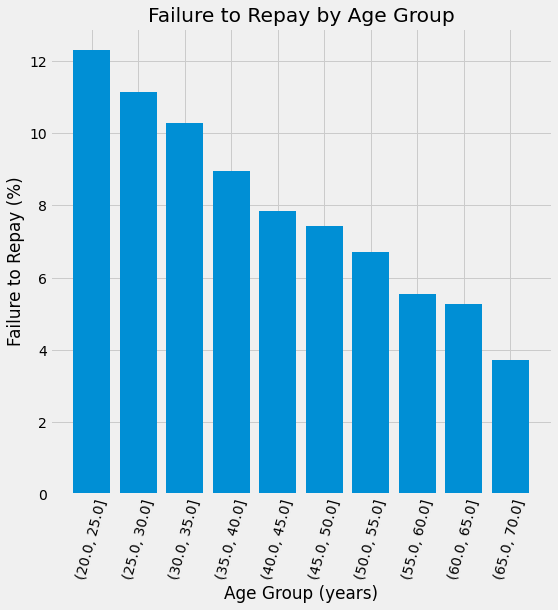

In [50]:
plt.figure(figsize= (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation=75)
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

분명한 경향이 있습니다: 젊은 지원자들은 대출금을 상환하지 않을 가능성이 더 높습니다! 상환불능률은 3번째 연령대까지 10% 이상, 최고령 연령대가 5% 이하입니다.

이것은 은행이 직접 사용할 수 있는 정보입니다. 젊은 고객들이 대출금을 상환할 가능성이 낮기 때문에, 그들에게 더 많은 안내나 재정 계획 팁을 제공해야 할 수도 있습니다. 이것은 은행이 젊은 고객들을 차별해야 한다는 것을 의미하지는 않지만, 젊은 고객들이 제때 돈을 지불할 수 있도록 예방 조치를 취하는 것이 현명할 것입니다.

### Exterior Sources
타겟과 가장 강한 음의 상관관계를 갖는 세 변수는 EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3 입니다. 설명에 따르면 이 피처들은 '외부 데이터 원본에서 정규화된 점수'를 나타냅니다. 정확한 뜻은 알 수 없지만. 수 많은 자료들을 이용해서 만든 누적 신용등급일 수도 있습니다.

먼저 이 피처들의 상관 관계를 살펴보겠습니다.

In [52]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

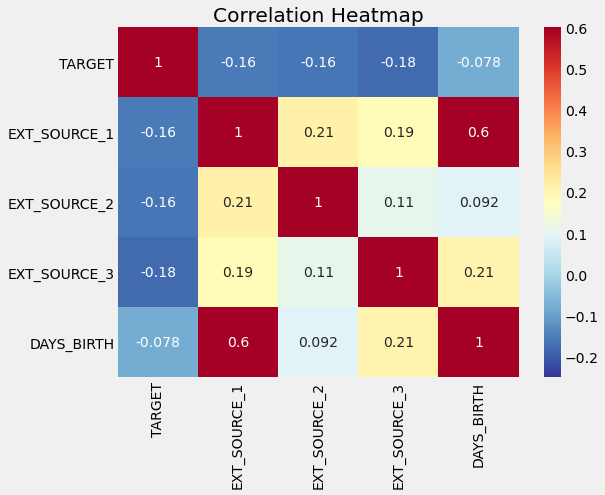

In [53]:
plt.figure(figsize=(8,6))

# Heatmap of corr
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=.6)
plt.title('Correlation Heatmap')

세가지 EXT_SOURCE 피처는 모두 타겟과 부정적인 상관관계를 가지고 있으며 EXT_SOURCE의 값이 증가할 수록 고객이 대출금을 상환할 가능성이 더 높다는 것을 나타냅니다. 또한 DAYS_BIRTH가 EXT_SOURCE1과 양의 상관관계를 가지고 있다는 것을 알 수 있습니다. 

다음에는 타겟값에 따라 색상이 지정된 각 피처의 분포를 살펴볼 수 있습니다. 이렇게 하면 이 변수가 타겟에 미치는 영향을 시각화 할 수 있습니다

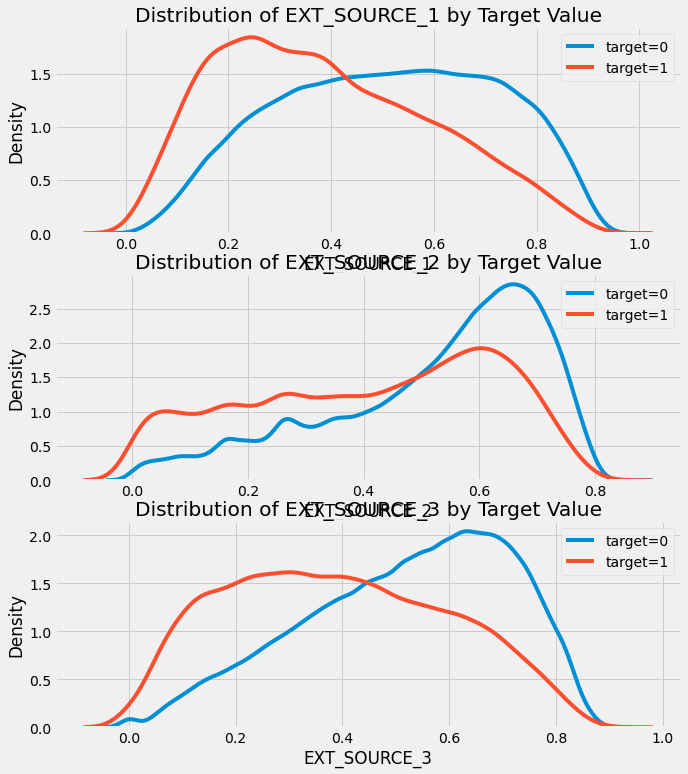

In [55]:
plt.figure(figsize=(10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i+1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label='target=0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label='target=1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' %source)
    plt.ylabel('Density')
    plt.legend()

EXT_SOURCE_3 은 타겟 값 간의 가장 큰 차이를 나타냅니다. 우리는 이 피처가 신청자가 대출금을 상환할 가능성과 어느 정도 관계가 있음을 알 수 있습니다.

### Pairplot
최종 탐색으로 EXT_SOURCE와 DAYS_BIRTH 변수의 쌍 그림을 만들 수 있습니다. 쌍 그림은 단일 변수의 분포뿐만 아니라 여러 변수 간의 관계를 확인 할 수 있기 때문에 훌륭한 탐색 도구입니다. 

Text(0.5, 0.98, 'Ext Source and Age Features Pair Plot')

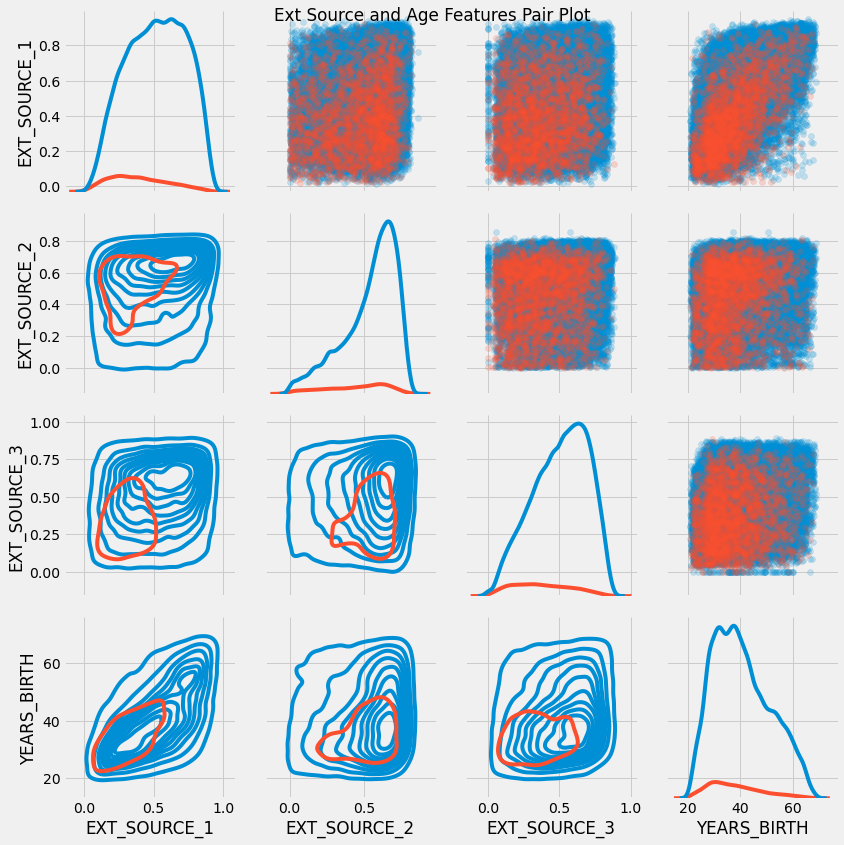

In [56]:
# Copy the data for plotting
plot_data = ext_data.drop(columns=['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000,:]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate('r = {:.2f}'.format(r),
               xy = (.2, .8), xycoords=ax.transAxes,
               size=20)
# Create the pairgrid object
grid = sns.PairGrid(data=plot_data, size=3, diag_sharey=False,
                   hue='TARGET', 
                   vars=[x for x in list(plot_data.columns) if x != 'TARGET'])
# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha=0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)

plt.suptitle('Ext Source and Age Features Pair Plot')

이 그림에서 빨간색은 상환되지 않은 대출을 나타내고 파란색은 상환된 대출입니다. 데이터 내에서 서로 다른 관계를 볼 수 있는데, EXT_SOURCE1과 DAYS_BIRTH(또는 이와 동등한 YEARS_BIRTH) 사이에 중간 정도의 양의 선형 관계가 있는 것으로 나타나 이 피처가 고객의 나이를 고려할 수 있음을 나타냅니다.

# Feature Engineering
피처 엔지니어링은 매우 중요합니다. 이는 모델 구축 및 하이퍼 파라미터 튜닝보다 효과가 높습니다. 

올바른 모형과 최적의 설정을 선택하는 것은 중요하지만, 모델은 주어진 데이터에서만 배울 수 있습니다. 이 데이터가 작업에 최대한 관련되도록 하는 것은 우리의 일입니다.

피처 엔지니어링은 일반적인 프로세스를 의미하며 기존 데이터에서 새로운 피처를 추가하고 피처 선택: 가장 중요한 피처만 선택하거나 차원 축소를 위한 다른 방법을 선택하는 두 가지 피처 구성을 모두 포함할 수 있습니다. 피처를 만들고 피처를 선택하는 데 사용할 수 있는 여러 가지 기술이 있습니다.

이 노트북에서는 두 가지 간단한 피처 구성 방법만 시도하겠습니다.
- Polynomial features
- Domain knowlege features

## Polynomial Features
이 방법에서는 기존 피처 간의 상호 작용 텀뿐만 아니라 기존 피처의 파워를 나타내는 피처도 만듭니다. 예를 들어 EXT_SOURCE_1^2, EXT_SOURCE_2^2, EXT_SOURCE_1 x EXT_SOURCE_2, EXT_SOURCE_1 x EXT_SOURCE_2^2, EXT_SOURCE_1^2 x EXT_SOURCE_2^2 변수 등을 생성할 수 있습니다. 여러 개별 변수의 조합인 이러한 피처는 변수 간의 교호작용을 나타냅니다. 즉, 두 변수 자체는 타겟에 큰 영향을 미치지 않지만 두 변수를 하나의 교호작용 변수로 결합하면 대상과의 관계가 나타날 수 있습니다. 교호작용 항은 통계 모델에서 여러 변수의 효과를 포착하기 위해 일반적으로 사용되지만 머신러닝에서 자주 사용되는 것으로 보이지는 않습니다. 그럼에도 불구하고 고객이 대출금을 상환할지 여부를 예측하는데 도움이 될 수 있는지 몇 가지를 시험해 볼 수 있습니다.

다음 코드에서는 EXT_SOURCE 변수와 DAYS_BIRTH 변수를 사용하여 다항식 피처를 만듭니다. 

In [57]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns=['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree=3)

In [58]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


상당한 수의 새로운 피처가 만들어집니다. 이름을 가져오겠습니다.

In [59]:
poly_transformer.get_feature_names(input_features=['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

최대 3차까지 생긴 개별 피처와 상호작용 항을 가진 35개의 피처가 있습니다. 이제 이러한 새로운 피처가 타겟과 상관관계가 있는지 확인할 수 있습니다.

In [60]:
# Create a dataframe of the features
poly_features = pd.DataFrame(poly_features, 
                            columns=poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


새 변수 중 몇 개는 원래 피처보다 타겟과 더 큰 상관관계를 가지고 있습니다. 머신러닝 모델을 구축할 때 이러한 피처를 사용하거나 사용하지 않고 모델이 실제로 학습하는데 도움이 되는지 여부를 판단할 수 있습니다.

교육 및 테스트 데이터 사본에 이러한 기능을 추가한 다음 피처가 있는 모델과 없는 모델을 평가합니다.

In [61]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, columns=poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on='SK_ID_CURR', how='left')

# Merge polynomial features into test dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on='SK_ID_CURR', how='left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join='inner', axis=1)

# Print out the new shapes
print('Training data with polynomial features shape:', app_train_poly.shape)
print('Testing data with polynomial features shape:', app_test_poly.shape)

Training data with polynomial features shape: (307511, 275)
Testing data with polynomial features shape: (48744, 275)


## Domain Knowledge Features
완전히 옳지 않을 수 있지만, 이것을 '제한적인 금융 지식을 적용하려는 시도'로 부를 수도 있습니다. 이러한 관점에서 고객이 대출에 대해 채무불이행 여부를 확인하는 데 중요하다고 생각하는 사항을 가져오는 몇 가지 피처를 만들 수 있습니다. 
- CREDIT_INCOME_PERCENT: 고객의 수입에 상대적인 신용 금액의 백분율입니다.
- ANNUITY_INCOME_PERCENT: 고객의 소득 대비 대출 연금의 백분율입니다.
- CREDIT_TERM: 연금을 지불한 기간입니다.
- DAYS_EMPLOYED_PERCENT: 고객의 연령에 비례하여 고용된 날의 백분율입니다.

In [66]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [67]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

### Visualize New Variables
도메인 지식 변수를 시각적으로 확인해 보겠습니다.

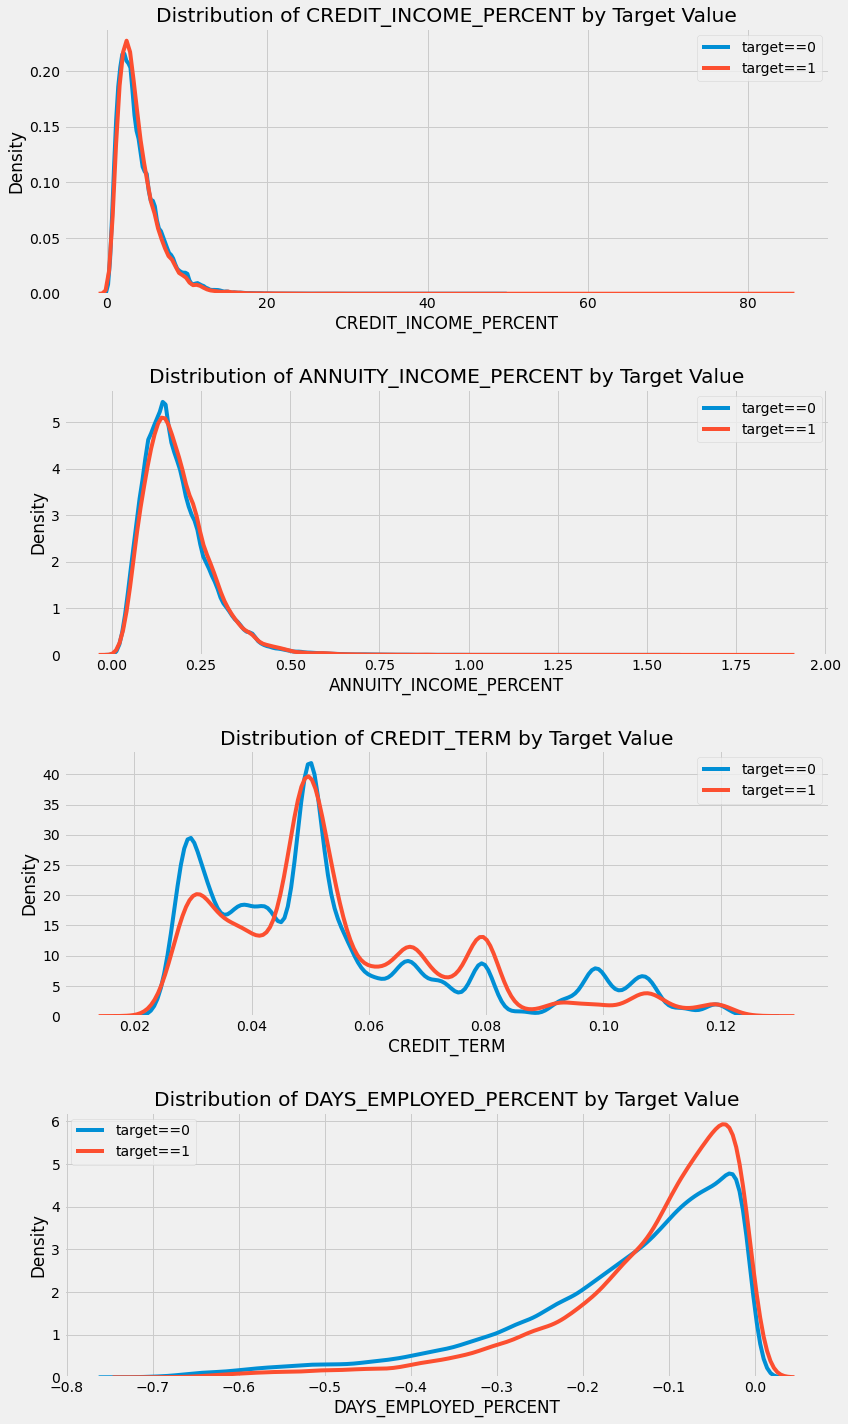

In [69]:
plt.figure(figsize=(12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i+1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET']==0, feature], label='target==0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET']==1, feature], label='target==1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' %feature)
    plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

# Baseline
단순한 기준선의 경우 테스트 셋의 모든 예에 대해 동일한 값을 추측할 수 있습니다. 대출금을 상환하지 않을 확률을 예측해야 하므로, 완전히 확신이 서지 않으면 테스트 셋의 모든 관측치에 대해 0.5를 추측할 수 있습니다. 이를 통해 우리는 0.5의 AUC ROC을 얻을 수 있습니다.

좀더 정교한 모델을 사용하겠습니다. 로지스틱 회귀 분석입니다.

# Logistic Regression Implementation
기준선을 얻기 위해 범주형 변수를 인코딩한 후 모든 피처를 사용할 것입니다. 결측치를 채우고 피처 범위를 정규화하여 전처리합니다. 

In [70]:
from sklearn.preprocessing import MinMaxScaler

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns=['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape:', train.shape)
print('Testing data shape:', test.shape)

Training data shape: (307511, 240)
Testing data shape: (48744, 240)


In [71]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularizaion parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001)

이제 모델이 훈련되었으므로 예측에 사용할 수 있습니다. 우리는 대출금을 지불하지 않을 확률을 예측하고 싶기 때문에 proba 방법을 사용합니다. 이는 m x 2 배열을 반환합니다. m은 관측치 수입니다. 첫째 열은 타겟=0, 둘째 열은 타겟=1일 확률입니다. ( 두 열 합계는 1) 우리는 대출금이 상환되지 않는 확률을 원하기 때문에 둘째 열을 선택하겠습니다.

In [72]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:,1]

이체 형식에 맞춰 제출 파일을 만듭니다,

In [73]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.078515
1,100005,0.137926
2,100013,0.082194
3,100028,0.080921
4,100038,0.132618


이 예측은 대출금이 상환되지 않을 확률을 0과 1로 나타냅니다. 이러한 예측을 사용하여 지원자를 분류하는 경우, 대출이 위험하다고 판단할 수 있는 확률 임계값을 설정할 수 있습니다.

In [74]:
# Save the submission to a csv file
submit.to_csv('log_reg_baseline.csv', index=False)

# Improved Model: Random Forest
기준선의 저조한 성능을 극복하기 위해 알고리즘을 업데이트 할 수 있습니다. 동일한 트레이닝 데이터에 랜덤 포레스트를 사용하여 성능에 어떤 영향을 미치는지 살펴보겠습니다. 랜덤 포레스트는 특히 수백개의 트리를 사용할 때 훨씬 더 강력한 모델입니다. 우리는 100개의 트리를 사용하겠습니다.

In [75]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)

In [76]:
# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importance
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


In [77]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index=False)

### Make Predictions using Engineered Features
다항식 특성 및 도메인 지식이 모델을 개선했는지 확인하는 유일한 방법은 이러한 피처에 대해 모델을 테스트하는 것입니다. 그 후 이러한 피처가 없는 모델의 제출 스코어와 비교하여 효과를 측정할 수 있습니다.

In [79]:
poly_features_names = list(app_train_poly.columns)

# Impute the polymonial features
imputer = SimpleImputer(strategy='median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.fit_transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range=(0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)

In [80]:
# Train on the training data
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[:,1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [81]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_engineered.csv', index=False)

결과가 더 안좋아졌습니다. 별로 도움이 되지 않았네요.

### Testing Domain Features

In [82]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = SimpleImputer(strategy='median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range=(0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.fit_transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[:,1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [84]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_domain.csv', index=False)

# Model Interpretation: Feature Importances
가장 관련성이 높은 변수를 확인하는 간단한 방법으로 랜덤포레스트의 피처 중요도를 살펴볼 수 있습니다. EDA에서 확인한 상관관계를 고려할 때 가장 중요한 피처는 EXT_SOURCE와 DAYS_BIRTH라고 예상해야 합니다. 향후 작업에서 차원 축소로 이러한 피처 중요도를 사용할 수 있습니다.

In [87]:
def plot_feature_importances(df):
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    # Make a horizontal bar chart of feature importances
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_normalized'].head(15),
           align='center', edgecolor='k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances')
    plt.show()
    
    return df

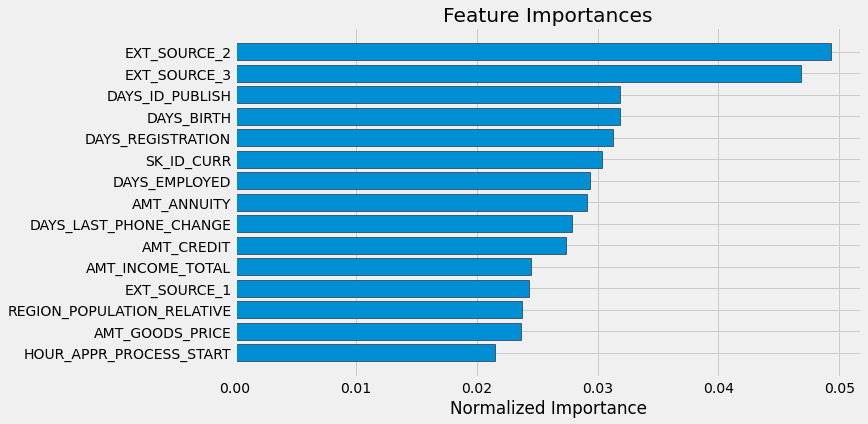

In [88]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

예상대로 가장 중요한 피처는 EXT_SOURCE와 DAYS_BIRTH을 다루는 피처입니다. 모델에 중요한 피처가 몇 개밖에 없다는 것을 알 수 있습니다. 따라서 성능 저하 없이 많은 피처를 제거할 수 있습니다. (성능이 향상될 수도 있습니다.) 피처 중요도는 모델을 해석하거나 차원 축소를 수행하는 가장 정교한 방법은 아니지만, 모델이 예측을 할 때 어떤 요인을 고려하는지 이해할 수 있게 해줍니다.

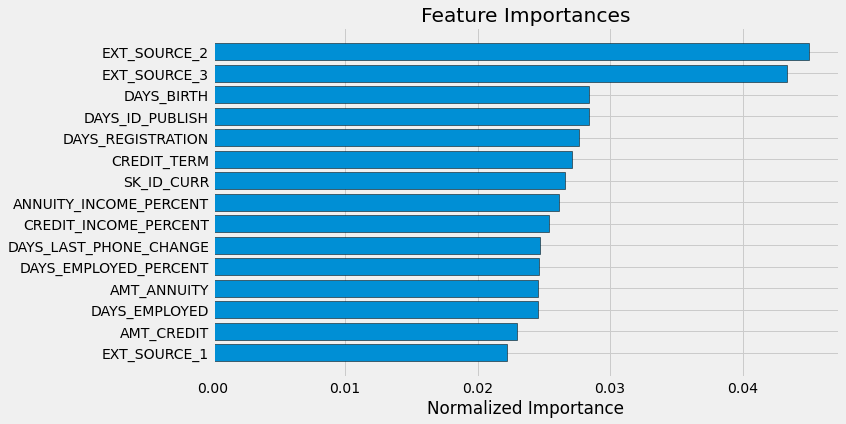

In [89]:
feature_importance_domain_sorted = plot_feature_importances(feature_importances_domain)

우리가 만든 네 가지 피처가 모두 상위 15위 안에 든 것을 알 수 있습니다.



# Light Gradient Boosting Machine
이번에는 LightGBM 라이브러리를 사용하는 Gradient Boosting Machine을 사용해보겠습니다. 

In [92]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds=5):
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR' , 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join='inner', axis=1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.fit_transform(np.array(test_features[col].astype(str)).reshape((-1,)))
                # Record the categorical indices
        
        # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("'Encoding must be either 'ohe' of 'le'")
        
    print('Training Data Shape:', features.shape)
    print('Testing Data Shape:', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle=True, random_state=50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recordion validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective='binary', class_weight = 'balanced', learning_rate=0.05, reg_alpha=0.1, reg_lambda=0.1, subsample = 0.8, n_jobs=-1, random_state=50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric= 'auc',
                 eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                 eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                 early_stopping_rounds = 100, verbose=200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1]/k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:,1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                           'train': train_scores,
                           'valid': valid_scores})
    
    return submission, feature_importances, metrics
            

In [93]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

Training Data Shape: (307511, 239)
Testing Data Shape: (48744, 239)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798723	train's binary_logloss: 0.547797	valid's auc: 0.755039	valid's binary_logloss: 0.563266
[400]	train's auc: 0.82838	train's binary_logloss: 0.518334	valid's auc: 0.755107	valid's binary_logloss: 0.545575
Early stopping, best iteration is:
[315]	train's auc: 0.816657	train's binary_logloss: 0.530116	valid's auc: 0.755215	valid's binary_logloss: 0.552627
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798409	train's binary_logloss: 0.548179	valid's auc: 0.758332	valid's binary_logloss: 0.563587
[400]	train's auc: 0.828244	train's binary_logloss: 0.518308	valid's auc: 0.758563	valid's binary_logloss: 0.545588
Early stopping, best iteration is:
[317]	train's auc: 0.8169	train's binary_logloss: 0.529878	valid's auc: 0.758754	valid's binary_logloss: 0.552413
Training until validation scores don't improv

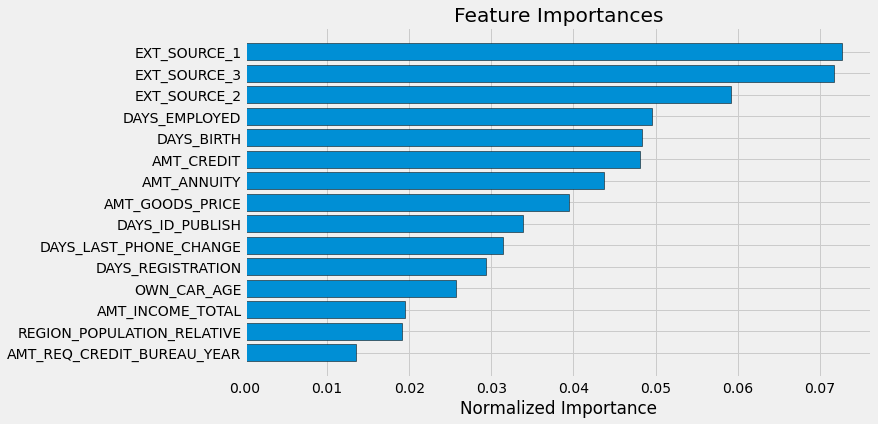

In [94]:
fi_sorted = plot_feature_importances(fi)

In [95]:
submission.to_csv('baseline_lgb.csv', index=False)

In [96]:
app_train_domain['TARGET'] = train_labels

# Test the domain knowledge features
submission_domain, fi_domain, metrics_domain = model(app_train_domain, app_test_domain)
print('Baseline with domain knowledge features metrics')
print(metrics_domain)

Training Data Shape: (307511, 243)
Testing Data Shape: (48744, 243)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.804779	train's binary_logloss: 0.541283	valid's auc: 0.762511	valid's binary_logloss: 0.557227
Early stopping, best iteration is:
[268]	train's auc: 0.815523	train's binary_logloss: 0.530413	valid's auc: 0.763069	valid's binary_logloss: 0.550276
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.804016	train's binary_logloss: 0.542318	valid's auc: 0.765768	valid's binary_logloss: 0.557819
Early stopping, best iteration is:
[218]	train's auc: 0.807075	train's binary_logloss: 0.539112	valid's auc: 0.766062	valid's binary_logloss: 0.555952
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.8038	train's binary_logloss: 0.542856	valid's auc: 0.7703	valid's binary_logloss: 0.557925
[400]	train's auc: 0.834559	train's binary_logloss: 0.511454	valid's auc: 0.770511	valid's binary_lo

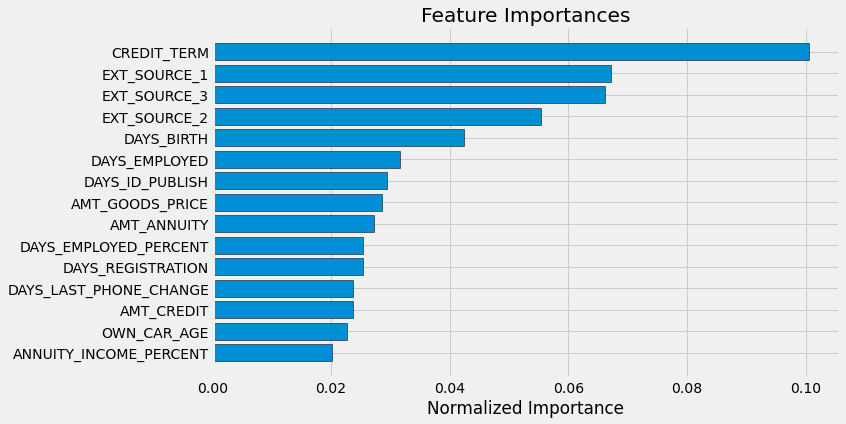

In [97]:
fi_sorted = plot_feature_importances(fi_domain)

도메인 지식이 도움을 준 것으로 보입니다.

In [98]:
submission_domain.to_csv('baseline_lgb_domain.csv', index=False)